# Market Efficiency in Betting Markets

In [42]:
import numpy as np
from scipy.stats import poisson
from scipy.stats import poisson,skellam
from scipy.optimize import minimize
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

## Reading the data:
The leagues which have been selected for this project are English Premier League (E0), Bundesliga (D1), French Ligue 1 (F1) and Eredivisie (N1) for the years 2019-2024.Reading the data, there multiple columns of data which ar not needed for this project so only a few have been selected.

In [20]:
Columns = ["Div","Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR","AvgH","AvgD","AvgA","Avg>2.5","Avg<2.5",
           "AvgCH","AvgCD","AvgCA","AvgC>2.5","AvgC<2.5"]

countries = ["N1","D1","F1","E0"]

In [21]:
Leagues = ["Netherlands","France","Germany","England"]
Years = ["2024","2023","2022","2021","2020"]
df_list = []

for i in Leagues:
    for j in Years:
        df = pd.read_csv("UK_Data_Site/"+i+"_"+j+'.csv',usecols=Columns)
        df_list.append(df)

df_total = pd.concat(df_list)

for i in range(0,len(df_total)):
    df_total["Date"].values[i] = datetime.strptime(df_total["Date"].values[i], "%d/%m/%Y")
    
day_diff = (df_total["Date"].values-df_total["Date"].min())

event_day = np.zeros(len(day_diff))
for i in range(0,len(day_diff)):
    event_day[i] = day_diff[i].days

df_total["season"] = event_day//360
df_total.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,AvgH,AvgD,AvgA,Avg>2.5,Avg<2.5,AvgCH,AvgCD,AvgCA,AvgC>2.5,AvgC<2.5,season
0,N1,2023-08-11 00:00:00,Volendam,Vitesse,1,2,A,3.37,3.74,2.04,1.56,2.39,3.73,3.83,1.91,1.56,2.40,4.0
1,N1,2023-08-12 00:00:00,PSV Eindhoven,Utrecht,2,0,H,1.36,5.21,7.94,1.49,2.58,1.29,5.73,9.43,1.45,2.70,4.0
2,N1,2023-08-12 00:00:00,Heerenveen,Waalwijk,3,1,H,1.75,4.03,4.26,1.57,2.36,1.57,4.32,5.37,1.56,2.40,4.0
3,N1,2023-08-12 00:00:00,Ajax,Heracles,4,1,H,1.18,7.73,13.26,1.34,3.20,1.24,6.72,10.63,1.35,3.14,4.0
4,N1,2023-08-12 00:00:00,Zwolle,Sparta Rotterdam,1,2,A,2.47,3.43,2.78,1.76,2.04,2.57,3.52,2.64,1.75,2.07,4.0


Theoretically we expect the closing lines to be more accurate since information have been added from the market participants. Firtly, we compare average and closing lines of match result odds for the given leagues for the actual result that happend.

In [22]:
def PnL(df=df_total, Div = None):
    '''This function returns the difference of Profit and loses (PnL) between the opening and closing odds for 
        all the given league or a specific league.'''
    
    if Div !=None:
        df = df[df["Div"]==Div]

    a = np.array(df["AvgH"]).reshape(len(df["AvgH"]),1)
    b = np.array(df["AvgD"]).reshape(len(df["AvgH"]),1)
    c = np.array(df["AvgA"]).reshape(len(df["AvgH"]),1)
    avg_odds = np.concatenate([a,b,c], axis = 1)

    a = np.array(df["AvgCH"]).reshape(len(df["AvgH"]),1)
    b = np.array(df["AvgCD"]).reshape(len(df["AvgH"]),1)
    c = np.array(df["AvgCA"]).reshape(len(df["AvgH"]),1)
    avg_C_odds = np.concatenate([a,b,c], axis = 1)


    resu = np.zeros((len(df),3))
    PnL = np.zeros(len(df))

    resu[:,0] = df["FTR"]=="H"
    resu[:,1] = df["FTR"]=="D"
    resu[:,2] = df["FTR"]=="A"
    PnL_table = resu*(avg_odds-avg_C_odds)

    for i in range(0,len(df["AvgH"])):
        PnL[i] = PnL_table[i,:].sum()
        
    return PnL

Mean of difference between Avg and Closing lines is 0.33 %, with std  34.0 %


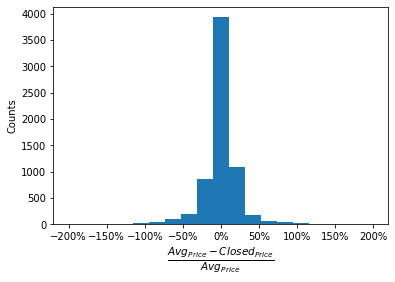

In [23]:
PnL_all = PnL()

bins = np.linspace(-2,2,20)
a = plt.hist(PnL_all,bins = bins)
plt.xlabel(r'$\frac{Avg_{Price}-Closed_{Price}}{Avg_{Price}} $', fontsize=15)
plt.ylabel('Counts')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))

print("Mean of difference between Avg and Closing lines is",np.round(100*np.mean(PnL_all),2),
      "%, with std ",np.round(100*np.std(PnL_all),2),"%")

(Price_avg - Price_closed)/Price_avg
League: N1 , mean= 0.61 %, std= 32.0 %
League: D1 , mean= -0.2 %, std= 35.0 %
League: F1 , mean= 0.33 %, std= 32.0 %
League: E0 , mean= 0.53 %, std= 36.0 %


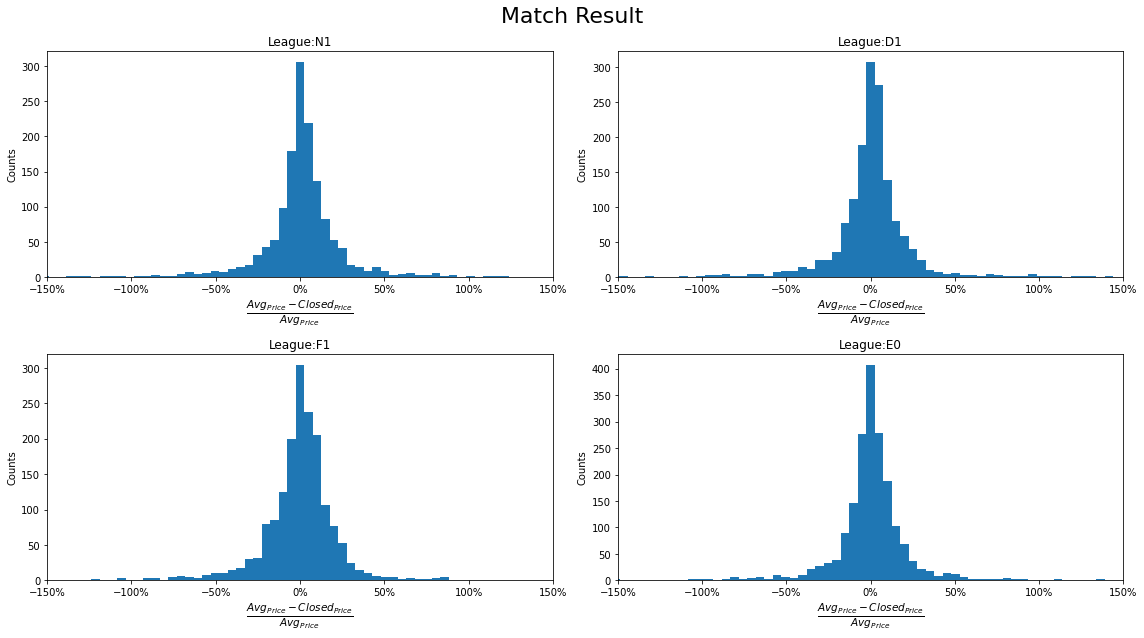

In [24]:
print("(Price_avg - Price_closed)/Price_avg")

countries = ["N1","D1","F1","E0"]
k = 0
bins = np.linspace(-2.5,2.5,100)
fig, axs = plt.subplots(2, 2,figsize=(16,9))
for i in range(0,2):
    for j in range(0,2):
        PNL = PnL(df=df_total, Div = countries[k])
        t_stat, p_value = stats.ttest_1samp(PNL, 0)
        axs[i, j].hist(PNL,bins=bins)
        print("League:",countries[k],", mean=",np.round(100*np.mean(PNL),2),"%, std=",
              np.round(100*np.std(PNL)),"%")
        axs[i, j].set_title('League:'+countries[k])
        axs[i, j].set_xlabel(r'$\frac{Avg_{Price}-Closed_{Price}}{Avg_{Price}} $', fontsize=15)
        axs[i, j].set_ylabel('Counts')
        axs[i, j].xaxis.set_major_formatter(PercentFormatter(1))
        axs[i, j].set_xlim(-1.5,1.5)
        k += 1

        
fig.suptitle('Match Result', fontsize=22)
plt.tight_layout()
plt.show()

The difference between average and closing odds' PnL is positive as expected since betting at closing lines leads to less profit. But knowing that the margin of this market ranges from 3%-7% the overall (and each league) PnL difference is well below that values' range at <1%.   

But the approach followed above ignores the differences of draw and win odds. Football models are based on the poisson distribution and for the case of non large difference between the strength of playing teams the odds of the draw have a limited range of prices and price changes are smaller compare to home or away win. So the same approach have to be applied for home/away and draw odds individually.

(Price_avg - Price_closed)/Price_avg
League: N1 , mean= 1.3 %, std= 32.0 %
League: D1 , mean= -1.41 %, std= 37.0 %
League: F1 , mean= -0.33 %, std= 34.0 %
League: E0 , mean= 0.66 %, std= 40.0 %


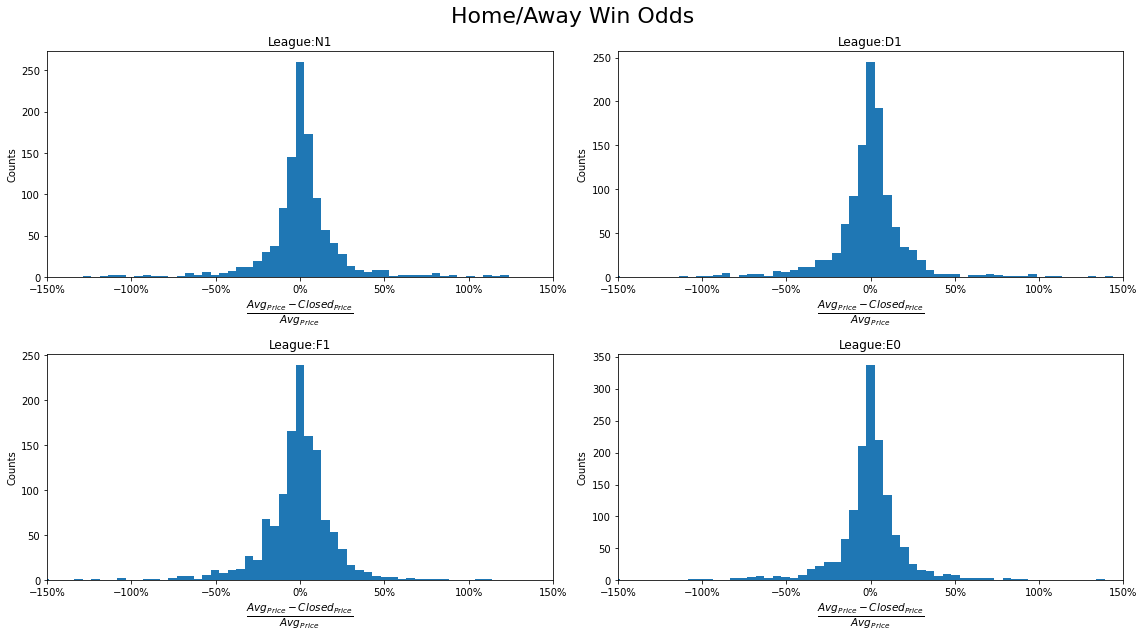

In [25]:
print("(Price_avg - Price_closed)/Price_avg")
df_11 = df_total[(df_total["FTR"]=="H")+(df_total["FTR"]=="A")]
k = 0
bins = np.linspace(-2.5,2.5,100)
fig, axs = plt.subplots(2, 2,figsize=(16,9))
for i in range(0,2):
    for j in range(0,2):
        PNL = PnL(df=df_11, Div = countries[k])
        axs[i, j].hist(PNL,bins=bins)
        print("League:",countries[k],", mean=",np.round(100*np.mean(PNL),2),"%, std=",
              np.round(100*np.std(PNL)),"%")
        axs[i, j].set_xlabel(r'$\frac{Avg_{Price}-Closed_{Price}}{Avg_{Price}} $', fontsize=15)
        axs[i, j].set_ylabel('Counts')
        axs[i, j].set_title('League:'+countries[k])
        axs[i, j].xaxis.set_major_formatter(PercentFormatter(1))
        axs[i, j].set_xlim(-1.5,1.5)
        k += 1
        
fig.suptitle('Home/Away Win Odds', fontsize=22)
plt.tight_layout()
plt.show()

(Price_avg - Price_closed)/Price_avg
League: N1 , mean= -1.65 %, std= 30.0 %
League: D1 , mean= 3.49 %, std= 27.0 %
League: F1 , mean= 2.25 %, std= 26.0 %
League: E0 , mean= 0.1 %, std= 21.0 %


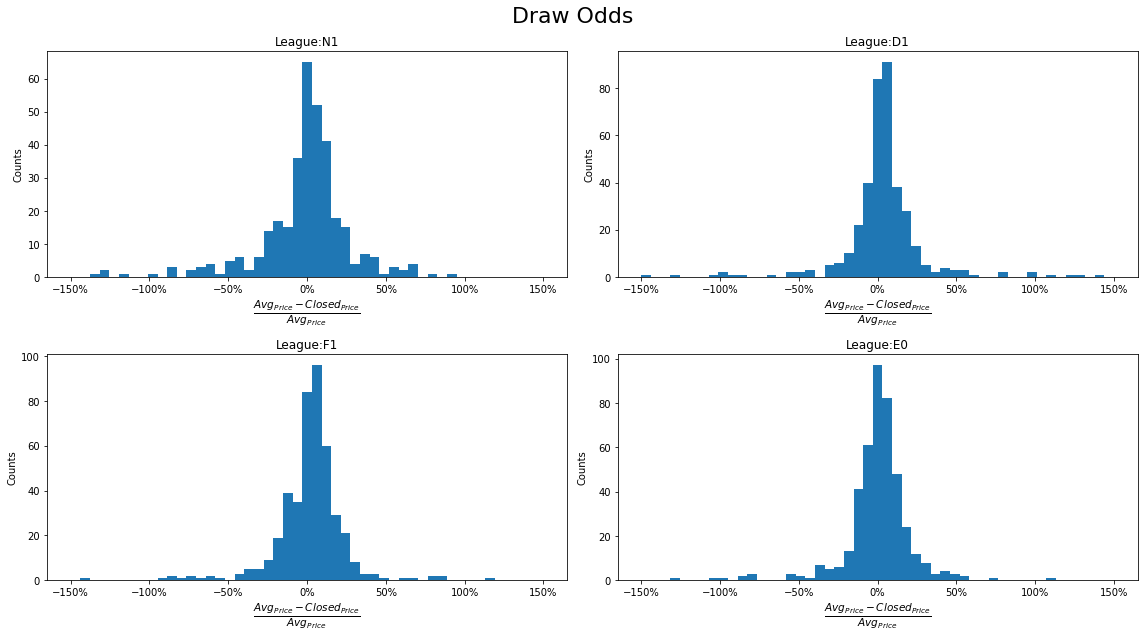

In [26]:
print("(Price_avg - Price_closed)/Price_avg")
df_11 = df_total[(df_total["FTR"]=="D")]
k = 0
bins = np.linspace(-1.5,1.5,50)
fig, axs = plt.subplots(2, 2,figsize=(16,9))
for i in range(0,2):
    for j in range(0,2):
        PNL = PnL(df=df_11, Div = countries[k])
        axs[i, j].hist(PNL,bins=bins)
        axs[i, j].set_xlabel(r'$\frac{Avg_{Price}-Closed_{Price}}{Avg_{Price}} $', fontsize=15)
        axs[i, j].set_ylabel('Counts')
        axs[i, j].set_title('League:'+countries[k])
        print("League:",countries[k],", mean=",np.round(100*np.mean(PNL),2),"%, std=",
              np.round(100*np.sqrt(np.var(PNL))),"%")
        axs[i, j].xaxis.set_major_formatter(PercentFormatter(1))
        k += 1
        
fig.suptitle('Draw Odds', fontsize=22)
plt.tight_layout()
plt.show()

It can be observed that the draw and home/away odds have different uncertainty as mentioned before due to the poisson distribution, while for the case of draw odds the lower the margin the lower the uncertainty. These results include two different scenarios, in one case the information provided by the market shifts prices due to additional information regarding the teams and in the other prices change by random steps due to the nature of a free market.

So lastly we have to study the cases of large odds' changes larger than the upper margin limit of 7%, does the market provide crucial information?

(Price_avg - Price_closed)/Price_avg
League: N1 , mean= 11.74 %, std= 43.0 %
League: D1 , mean= 9.38 %, std= 47.0 %
League: F1 , mean= 0.1 %, std= 55.0 %
League: E0 , mean= 9.04 %, std= 49.0 %


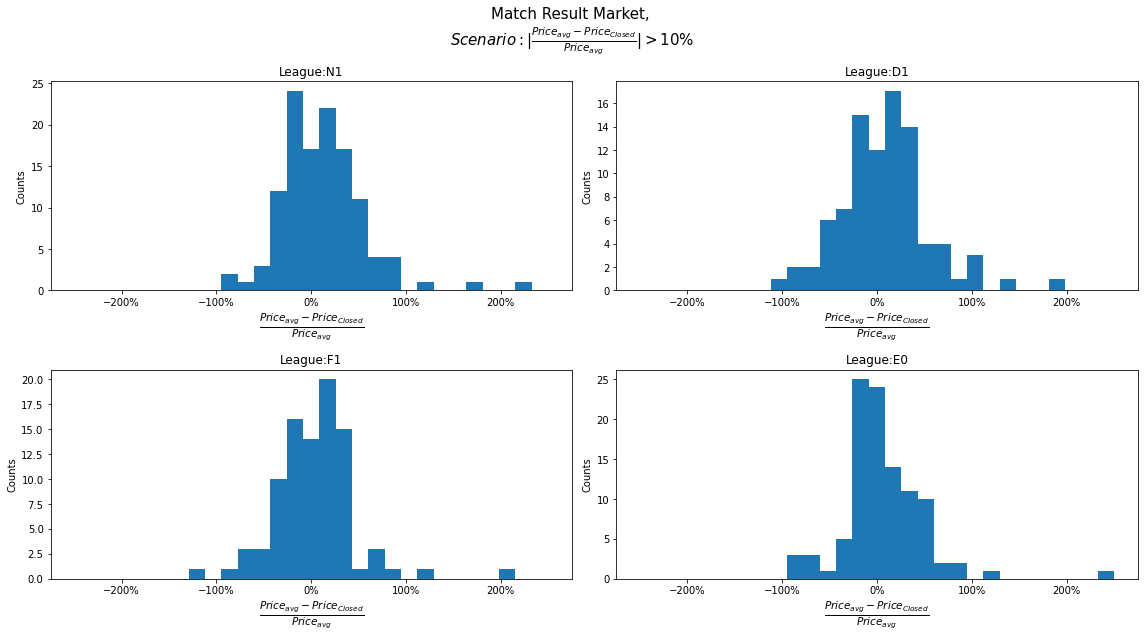

In [27]:
print("(Price_avg - Price_closed)/Price_avg")
df_11 = df_total[((df_total["AvgH"]-df_total["AvgCH"])/df_total["AvgH"])>0.1]
k = 0
bins = np.linspace(-2.5,2.5,30)
fig, axs = plt.subplots(2, 2,figsize=(16,9))
for i in range(0,2):
    for j in range(0,2):
        PNL = PnL(df=df_11, Div = countries[k])
        axs[i, j].hist(PNL,bins=bins)
        print("League:",countries[k],", mean=",np.round(100*np.mean(PNL),2),"%, std=",
              np.round(100*np.sqrt(np.var(PNL))),"%")
        axs[i, j].set_xlabel(r'$\frac{Price_{avg}-Price_{Closed}}{Price_{avg}} $', fontsize=15)
        axs[i, j].set_ylabel('Counts')
        axs[i, j].set_title('League:'+countries[k])
        axs[i, j].xaxis.set_major_formatter(PercentFormatter(1))
        k += 1

fig.suptitle('Match Result Market, \n' + r'$ Scenario : \| \frac{Price_{avg}-Price_{Closed}}{Price_{avg}} \| >  10 \% $' , fontsize = 15)
plt.tight_layout()
plt.show()

(Price_avg - Price_closed)/Price_avg
League: N1 , mean= -0.21 %, std= 26.0 %
League: D1 , mean= -0.47 %, std= 34.0 %
League: F1 , mean= -0.41 %, std= 21.0 %
League: E0 , mean= 0.15 %, std= 22.0 %


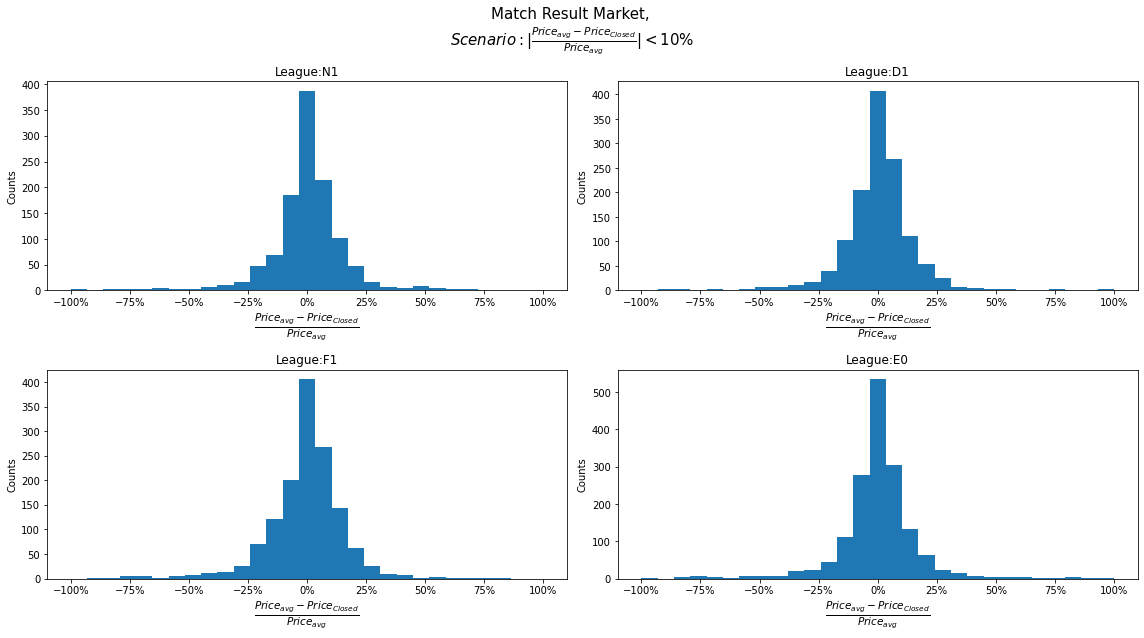

In [28]:
print("(Price_avg - Price_closed)/Price_avg")
df_11 = df_total[((np.abs(df_total["AvgH"]-df_total["AvgCH"])/df_total["AvgH"])<0.1)]
k = 0
bins = np.linspace(-1,1,30)
fig, axs = plt.subplots(2, 2,figsize=(16,9))
for i in range(0,2):
    for j in range(0,2):
        PNL = PnL(df=df_11, Div = countries[k])
        axs[i, j].hist(PNL,bins=bins)
        print("League:",countries[k],", mean=",np.round(100*np.mean(PNL),2),"%, std=",
              np.round(100*np.sqrt(np.var(PNL))),"%")
        axs[i, j].set_xlabel(r'$\frac{Price_{avg}-Price_{Closed}}{Price_{avg}} $', fontsize=15)
        axs[i, j].set_ylabel('Counts')
        axs[i, j].set_title('League:'+countries[k])
        axs[i, j].xaxis.set_major_formatter(PercentFormatter(1))
        k += 1

fig.suptitle('Match Result Market, \n' + r'$ Scenario : \| \frac{Price_{avg}-Price_{Closed}}{Price_{avg}} \| <  10 \% $' , fontsize = 15)
plt.tight_layout()
plt.show()

The average punter comes once in his lifetime to a point thinking that markets moves by trends of big favs during the last hours before the game starts. The majority of punters tend to bet at momments close to the start of a game and the larger portion of football fans bet based on their team or the popularity of a team and thus they move the odds of the favorite lower that it should be. Unfortunatelly that's not how it works and it can be seen below by checking the difference of average and closing lines of the big favs included in our data (without considering the games between them since there isn't a large power difference). Closing lines beat the average line bby a similar % compared to all odds which shows that odds movements are mostly random.

In [29]:
big_favorites = ['Ajax','Arsenal','Bayern Munich','Dortmund','Feyenoord',
 'Liverpool','Man City','Man United','Paris SG','RB Leipzig','PSV Eindhoven']

PNL_favs = np.array([])
df = df_total.copy()
for i in big_favorites:
    df_1 = df[(df["HomeTeam"]==i)+(df["AwayTeam"]==i)]
    for j in big_favorites:
        if i!=j:
            df_1 = df_1[(df_1["HomeTeam"]!=j)+(df_1["AwayTeam"]!=j)]
            #print(j)
    PNL = PnL(df=df_1)
    PNL_favs = np.append(PNL_favs,PNL)


print("Mean of difference between Avg and Closing lines is",np.round(100*np.mean(PNL_favs),2),
      "%, with std ",np.round(100*np.std(PNL_favs),2),"%")

Mean of difference between Avg and Closing lines is 0.47 %, with std  50.66 %


Below some stats are presented for each league such as the average of total goals, home advantage (as percentage of away goals), average odds and home-away correlation. More goals and higher home advantage can lead to larger uncertainty in prices.

In [30]:
def league_stats(final_df = df_total,countries=countries):
    data = np.zeros((len(countries),6))    
    k = 0
    for i in countries:        
        df = final_df[final_df["Div"]==i]
        df_means = df.select_dtypes(np.number).mean()
        data[k,0] = df_means["FTHG"]/df_means["FTAG"] - 1
        data[k,1] = df_means["FTHG"]+df_means["FTAG"]
        data[k,2] = 1/df_means["AvgH"]-1/df_means["AvgA"]
        data[k,3] = 1/df_means["AvgD"]
        data[k,4] = 1/df_means["AvgA"]
        data[k,5] = np.corrcoef(df["FTHG"], df["FTAG"])[0,1]
        
        k += 1
        
    dataset = pd.DataFrame({'League': countries,'Home Adv': data[:, 0], 'Total Goals': data[:, 1],
                           'Home Win Avg Prob': data[:, 2], 'Draw Avg Prob': data[:, 3],
                           'Away Win Avg Prob': data[:, 4], 'Home-Away Corr Rho': data[:, 5]})
    
    return dataset
        
league_stats() 

,League,Home Adv,Total Goals,Home Win Avg Prob,Draw Avg Prob,Away Win Avg Prob,Home-Away Corr Rho
0,N1,0.264931,3.047390,0.130447,0.215838,0.200738,-0.186191
1,D1,0.253389,3.150327,0.123182,0.227797,0.229479,-0.184261
2,F1,0.187007,2.732174,0.130339,0.254816,0.241879,-0.068936
3,E0,0.193250,2.873158,0.118160,0.233015,0.216013,-0.152955


First of all the margin in each market is need in order to know bookies' advantage but also how much prices flactuate from the momment of release to closing time.

In [31]:
def margin(market = True, df = df_total, Div = "E0"):
    df = df[df["Div"]==Div]
    if market==True:
        margin = 1/df["AvgH"]+1/df["AvgD"]+1/df["AvgA"]
    else:
        margin = 1/df["Avg>2.5"]+1/df["Avg<2.5"]
    return margin

margin_league = np.zeros((4,len(countries)))
k = 0
for i in countries:
    m1x2 = margin(market = True, df = df_total, Div = i)
    m2_5 = margin(market = False, df = df_total, Div = i)
    print("League :",i,", 1x2 margin=",np.round(np.mean(m1x2),3),"+-",
          np.round(np.sqrt(np.var(m1x2)),3),", O/U 2.5 margin=",
          np.round(np.mean(m2_5),3),"+-",np.round(np.sqrt(np.var(m2_5)),3))
    margin_league[0,k] = 1-np.mean(m1x2)
    margin_league[1,k] = 1-np.mean(m2_5)
    margin_league[2,k] = np.sqrt(np.var(m1x2))
    margin_league[3,k] = np.sqrt(np.var(m2_5))
    k += 1

League : N1 , 1x2 margin= 1.058 +- 0.003 , O/U 2.5 margin= 1.057 +- 0.004
League : D1 , 1x2 margin= 1.045 +- 0.003 , O/U 2.5 margin= 1.051 +- 0.005
League : F1 , 1x2 margin= 1.049 +- 0.003 , O/U 2.5 margin= 1.051 +- 0.004
League : E0 , 1x2 margin= 1.042 +- 0.002 , O/U 2.5 margin= 1.048 +- 0.004


The bookies' 1x2 margin is lowest in English Premier League with Bundensliga to follow and then Ligue 1, with Eredivisie's being much higher than all three of them. The margin in O/U market is almost equal in all markets except eredivisie in which is much higher again. These observations are expected since the lower the margin the higher liquidity in betting exchanges. The margin ordering follows well the liquidity order, while the O/U lines are more reliable so the margin is almost equal in all big football leagues. In other hand Eredivisie is a less popular league in terms of betting and thus the high margin. Of course the margin is not a specific number but varies per bookie, so below the histogram of the margin in data we have is shown.

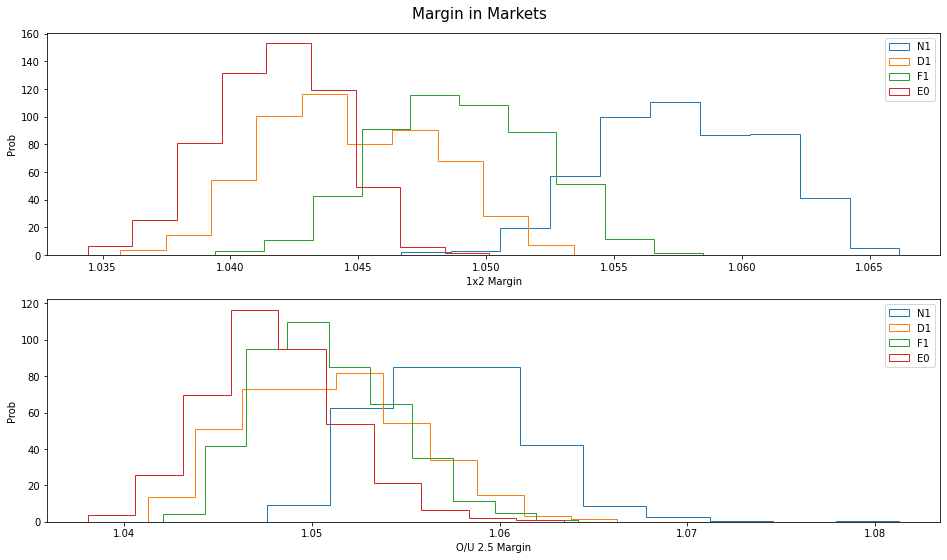

In [56]:
fig, axs = plt.subplots(2,figsize=(16,9))
k = 0
for i in countries:
    axs[0].hist(margin(market = True, df = df_total, Div = i),
             histtype=u'step', density=True)
    axs[1].hist(margin(market = False, df = df_total, Div = i),
             histtype=u'step', density=True)
    
axs[0].set_ylabel('Prob') 
axs[1].set_ylabel('Prob') 
axs[0].set_xlabel('1x2 Margin')
axs[1].set_xlabel('O/U 2.5 Margin')
axs[0].legend(countries)
axs[1].legend(countries)
fig.suptitle('Margin in Markets' , fontsize = 15, y = 0.92)
plt.show()

# Checking How accurate the betting markets are:

In order to check the reliabillity and accuracy of the market's prices a random walk simulation have to be created. The random betting selections follow a uniform distribution with 3 possible results in the case of 1x2 market and 2 possible results in the O/U 2.5 case. In each round the player risks a "unit" and if the player wins the winning odds minus the unit (minus 1) he bets is added in his PnL or a unit is substracted if his selection is a loser. The PnL in terms of units and the PnL% versus the betting rounds is presented below.

In [33]:
N_simulations = 10

def winning_odds(df = df_total,close = False):
    if close == True:
        a = np.array(df["AvgCH"]).reshape(len(df["AvgCH"]),1)
        b = np.array(df["AvgCD"]).reshape(len(df["AvgCH"]),1)
        c = np.array(df["AvgCA"]).reshape(len(df["AvgCH"]),1)
    else:
        a = np.array(df["AvgH"]).reshape(len(df["AvgH"]),1)
        b = np.array(df["AvgD"]).reshape(len(df["AvgH"]),1)
        c = np.array(df["AvgA"]).reshape(len(df["AvgH"]),1)
    
    avg_odds = np.concatenate([a,b,c], axis = 1)
    resu = np.zeros((len(df),3))
    odds_winning = np.zeros(len(df))

    resu[:,0] = df["FTR"]=="H"
    resu[:,1] = df["FTR"]=="D"
    resu[:,2] = df["FTR"]=="A"
    a = resu*avg_odds

    for i in range(0,len(df["AvgH"])):
        odds_winning[i] = a[i,:].sum()
        
    return odds_winning

def random_walk_betting1x2(N_simulations, df_1,suffle=True,close = False):
    odds_winning = winning_odds(df = df_1,close = close)
    results = ((df_1["FTR"]=="H")*0+(df_1["FTR"]=="D")*1+(df_1["FTR"]=="A")*2)
    pnl_bet = np.zeros((N_simulations,len(odds_winning)))
    for i in range(0,N_simulations):
        betting_selections = np.round((np.random.uniform(-0.5,2.5,len(odds_winning))))
        pnl_bet[i,:] = (odds_winning*(betting_selections==results)-1)
        if suffle==True:
            np.random.shuffle(pnl_bet[i,:])
    
    return pnl_bet

def Over_2_5_odds(df = df_total,suffle=True,N_simulations = N_simulations,close = False):
    
    results = (df["FTHG"]+df["FTAG"]) > 2.5
    winning_odds = results*df["Avg>2.5"]+(1-results)*df["Avg<2.5"]
    pnl_bet = np.zeros((N_simulations,len(winning_odds)))
    for i in range(0,N_simulations):
        betting_selections = np.round((np.random.uniform(-0.5,1.5,len(winning_odds))))
        pnl_bet[i,:] = (winning_odds*(betting_selections==results)-1)
    
    return pnl_bet


def portfolio_stats_1x2(N_simulations,df,suffle=True,market_1x2 = True,close = False): 
    if market_1x2 == True:
        bets = random_walk_betting1x2(N_simulations = N_simulations,df_1 = df,suffle=suffle,close = close)
    else:
        bets = Over_2_5_odds(df = df,suffle=suffle,N_simulations=N_simulations)
    
    sim_sumul_resu = np.zeros((N_simulations,len(bets[0,:])))
    for i in range(0,N_simulations):
        sim_sumul_resu[i,:] = np.cumsum(bets[i,:])
    
    round_stats = np.zeros((len(sim_sumul_resu[0,:]),2))
    for i in range(0,len(sim_sumul_resu[0,:])):
        round_stats[i,0] = np.mean(sim_sumul_resu[:,i])
        round_stats[i,1] = np.sqrt(np.var(sim_sumul_resu[:,i]))
    return round_stats

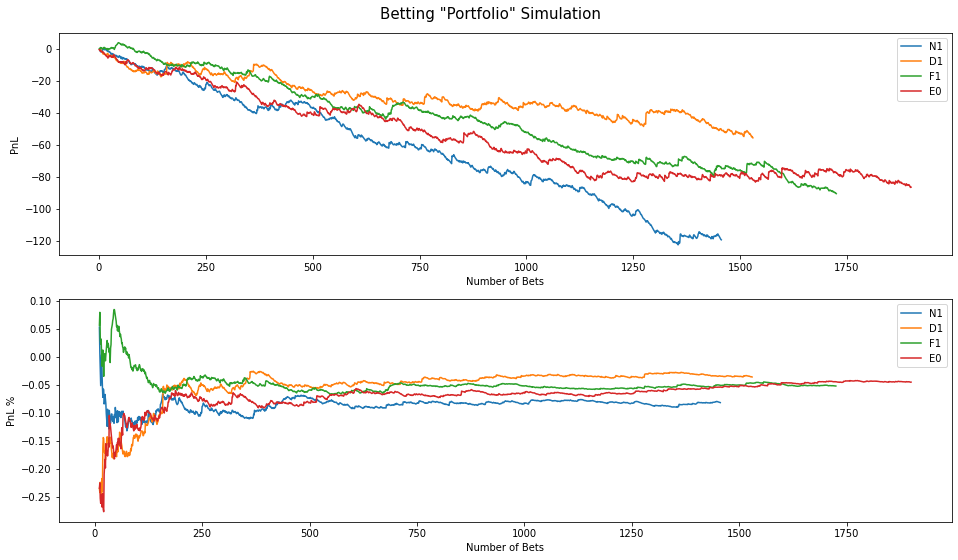

In [68]:
N_simulations = 2000
fig, axs = plt.subplots(2,figsize=(16,9))
k = 0
for i in countries:
    sim = portfolio_stats_1x2(N_simulations = N_simulations,
                              df = df_total[df_total["Div"]==i],suffle=False)
    
    no_bets = np.arange(1,1+len(sim[:,0]))
    axs[0].plot(no_bets,sim[:,0])
    axs[1].plot(no_bets[10:],sim[10:,0]/no_bets[10:])
    
axs[0].set_ylabel('PnL') 
axs[1].set_ylabel('PnL %') 
axs[0].set_xlabel('Number of Bets')
axs[1].set_xlabel('Number of Bets')
axs[0].legend(countries)
axs[1].legend(countries)
fig.suptitle('Betting "Portfolio" Simulation' , fontsize = 15, y = 0.92)
plt.show()

In the above results the date order of the events is shown and the noise is quite big more several hundreds of betting rounds. For more representive results the football events are shuffled in order to avoid effects from their date and as it can be seen below the PnL plots are much more smooth.

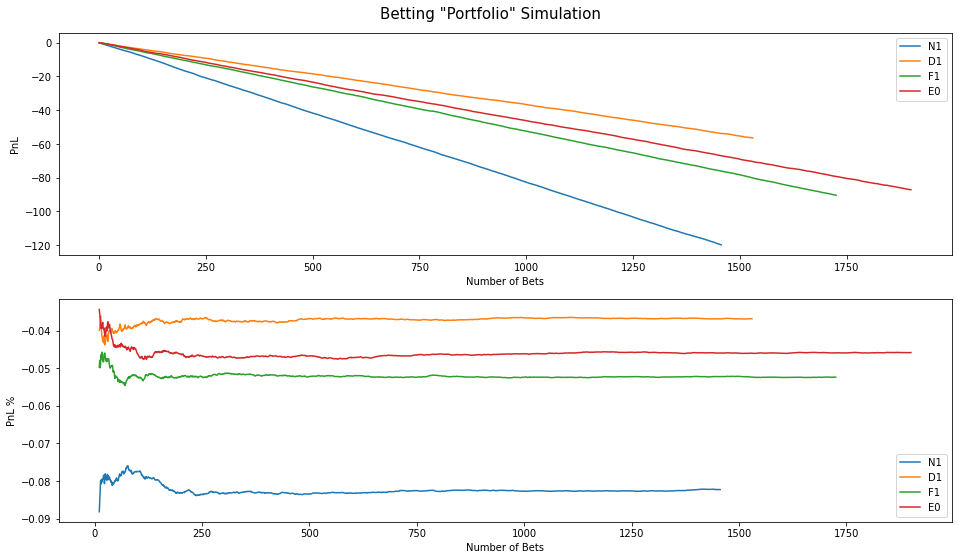

In [69]:
fig, axs = plt.subplots(2,figsize=(16,9))
k = 0
for i in countries:
    sim = portfolio_stats_1x2(N_simulations = N_simulations,
                              df = df_total[df_total["Div"]==i],suffle=True)
    
    no_bets = np.arange(1,1+len(sim[:,0]))
    axs[0].plot(no_bets,sim[:,0])
    axs[1].plot(no_bets[10:],sim[10:,0]/no_bets[10:])
    
axs[0].set_ylabel('PnL') 
axs[1].set_ylabel('PnL %') 
axs[0].set_xlabel('Number of Bets')
axs[1].set_xlabel('Number of Bets')
axs[0].legend(countries)
axs[1].legend(countries)
fig.suptitle('Betting "Portfolio" Simulation' , fontsize = 15, y = 0.92)
plt.show()

An interesting observation from the plot above is that Bundesliga seems to have lower loses than expected by it's prices' margin while in Eredivisie the opposite trend can be seen. This result can be explained either by market inefficiency or by non uniform margin application. 

For cases of very high odds (and thus small probabillity) even small changes in the favavorite's winning probabillity can change much more than 5% that the margin covers so a different approach is followed which is called power margin. As you see below Eredivisie has many more games with a very strong fav compared to the other leagues, which leads to many games with a very high priced underdog. Due to non uniform margin (more in high prices) the Eredivisie actual PnL is lower by 2% to 3% compared to the overall applied margin. 

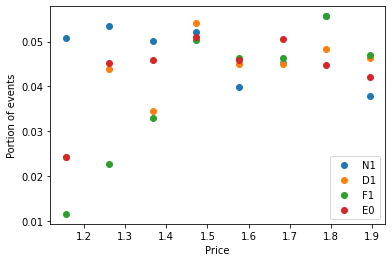

In [70]:
prices = np.linspace(1.05,2,10)
mid_price = prices+prices[1]-prices[0]
price_dist = np.zeros((len(countries),len(mid_price)-1))

for i in range(0,len(countries)):
    df = df_total[df_total["Div"] == countries[i]] 
    for j in range(0,len(prices)-2):
        price_dist[i,j] = len(df[(df["AvgH"]>prices[j])*(df["AvgH"]<prices[j+1])])/len(df)

for i in range(0,len(countries)):
    plt.scatter(mid_price[:8],price_dist[i,:8])

plt.legend(['N1', 'D1', 'F1', 'E0'])
plt.xlabel("Price")
plt.ylabel("Portion of events")
plt.show()

Below the mean with one standard deviation error of Pnl and Pnl% plots are shown for every 100 betting rounds for every league compared to the respected margin. The biggest failure of our random walk can be seen is Eredivisie (althought the margin is still within the error range), with Bundensliga to still show some difference to the expected result and Ligue 1, Premier League to be in perfect agreement with the expectations. 

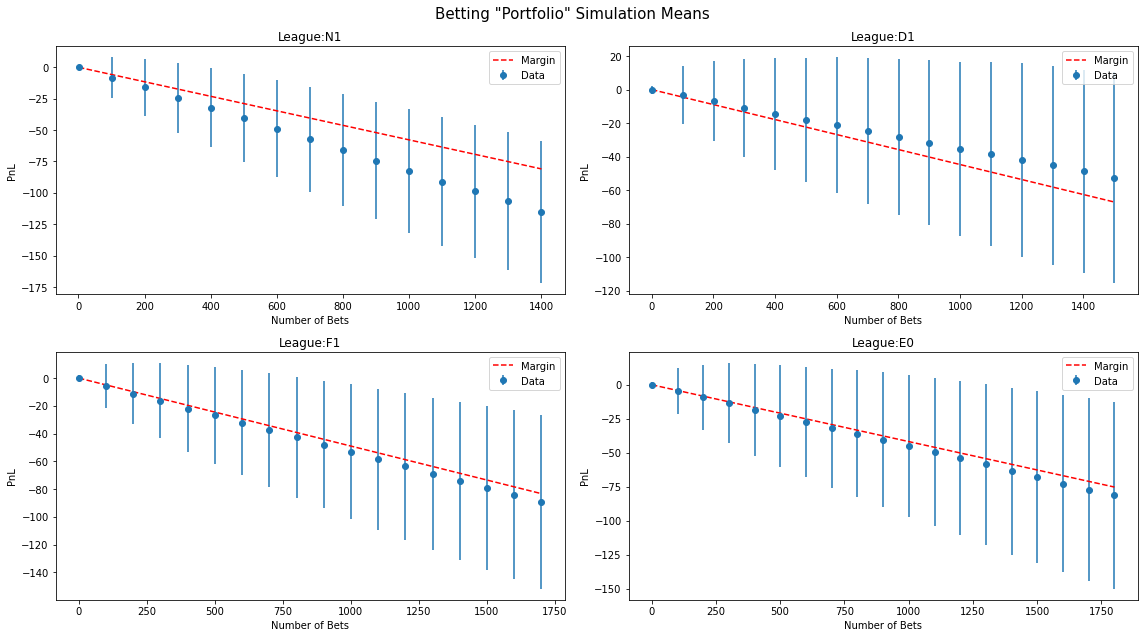

In [84]:
fig, axs = plt.subplots(2, 2,figsize=(16,9))
k = 0
for i in range(0,2):
    for j in range(0,2):
        sim = portfolio_stats_1x2(N_simulations = N_simulations,
                              df = df_total[df_total["Div"]==countries[k]])
        no_bets = np.arange(1,1+len(sim[:,0]),100)
        axs[i, j].errorbar(no_bets,sim[no_bets,0],yerr=sim[no_bets,1], fmt="o")
        
        axs[i, j].plot(no_bets,margin_league[0,k]*no_bets, color = 'r', linestyle = 'dashed')
        
        
        axs[i, j].set_title('League:'+countries[k])
        axs[i, j].set_xlabel('Number of Bets')
        axs[i, j].set_ylabel('PnL')
        axs[i, j].legend(["Margin","Data"])
        
        k += 1
        
fig.suptitle('Betting "Portfolio" Simulation Means' , fontsize = 15)
plt.tight_layout()
plt.show()

League: N1 ,Mean and margin absolute difference: 2.4 %
League: D1 ,Mean and margin absolute difference: 1.1 %
League: F1 ,Mean and margin absolute difference: 0.4 %
League: E0 ,Mean and margin absolute difference: 0.5 %


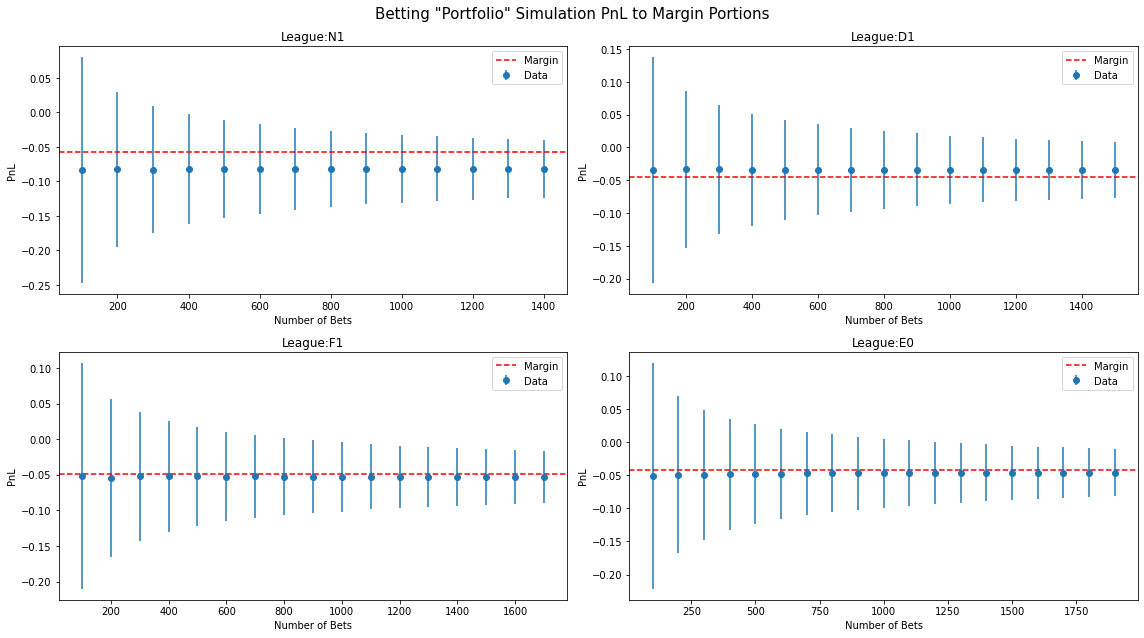

In [72]:
fig, axs = plt.subplots(2, 2,figsize=(16,9))
k = 0
for i in range(0,2):
    for j in range(0,2):
        sim = portfolio_stats_1x2(N_simulations = N_simulations,
                              df = df_total[df_total["Div"]==countries[k]])
        no_bets = np.arange(100,1+len(sim[:,0]),100)
        if no_bets[-1] == len(sim[:,0]):
            no_bets = np.arange(100,1+len(sim[:,0]),100)-1
        axs[i, j].errorbar(no_bets,sim[no_bets,0]/no_bets,
                           yerr=sim[no_bets,1]/no_bets, fmt="o")
        
        axs[i, j].axhline(y = margin_league[0,k], color = 'r', linestyle = 'dashed') 
        axs[i, j].set_title('League:'+countries[k])
        axs[i, j].set_xlabel('Number of Bets')
        axs[i, j].set_ylabel('PnL')   
        axs[i, j].legend(["Margin","Data"])
        print("League:",countries[k],",Mean and margin absolute difference:",
             np.round(100*abs(np.mean(sim[no_bets,0]/no_bets)-margin_league[0,k]),1),"%")
        k += 1
        
fig.suptitle('Betting "Portfolio" Simulation PnL to Margin Portions' , fontsize = 15)
plt.tight_layout()
plt.show()

The O/U 2.5 goals market's PnL and PnL% are presented in which the market success is obvious for every league after a couple of hundreds betting rounds.

League: N1 ,Mean and margin absolute difference: 0.6 %
League: D1 ,Mean and margin absolute difference: 1.6 %
League: F1 ,Mean and margin absolute difference: 0.3 %
League: E0 ,Mean and margin absolute difference: 1.5 %


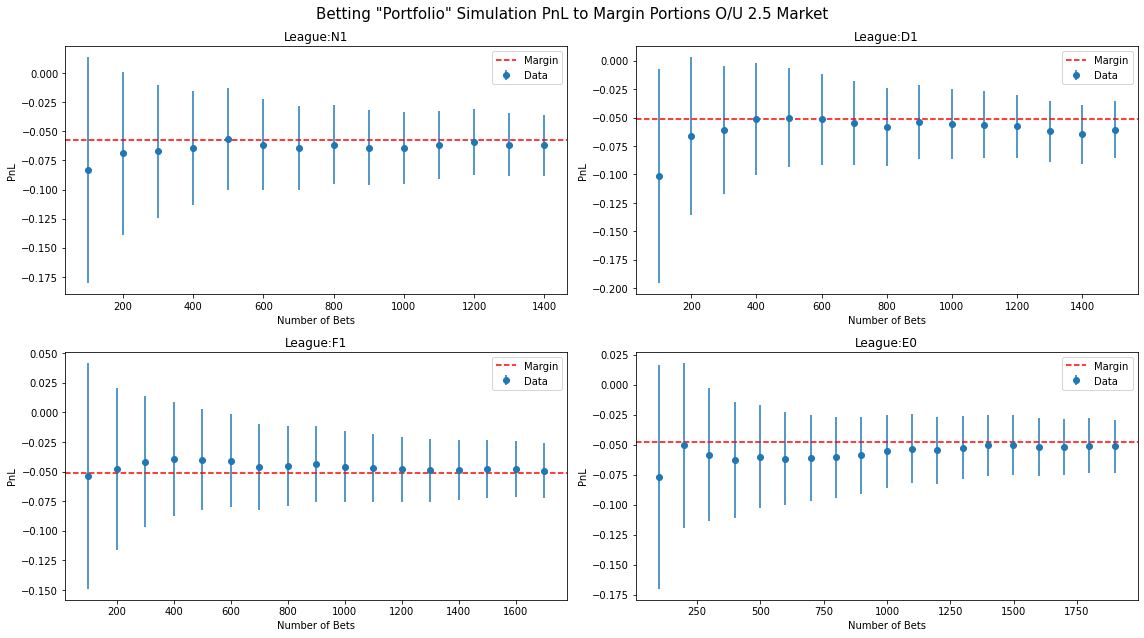

In [73]:
fig, axs = plt.subplots(2, 2,figsize=(16,9))
k = 0
for i in range(0,2):
    for j in range(0,2):
        sim = portfolio_stats_1x2(N_simulations = N_simulations,
                              df = df_total[df_total["Div"]==countries[k]],
                                  market_1x2 = False)
        no_bets = np.arange(100,1+len(sim[:,0]),100)
        if no_bets[-1] == len(sim[:,0]):
            no_bets = np.arange(100,1+len(sim[:,0]),100)-1
        axs[i, j].errorbar(no_bets,sim[no_bets,0]/no_bets,
                           yerr=sim[no_bets,1]/no_bets, fmt="o")

        axs[i, j].axhline(y = margin_league[1,k], color = 'r', linestyle = 'dashed') 
        axs[i, j].set_title('League:'+countries[k])
        axs[i, j].set_xlabel('Number of Bets')
        axs[i, j].set_ylabel('PnL')   
        axs[i, j].legend(["Margin","Data"])
        print("League:",countries[k],",Mean and margin absolute difference:",
             np.round(100*abs(np.mean(sim[no_bets,0]/no_bets)-margin_league[0,k]),1),"%")
        k += 1
        
fig.suptitle('Betting "Portfolio" Simulation PnL to Margin Portions O/U 2.5 Market' , fontsize = 15)
plt.tight_layout()
plt.show()

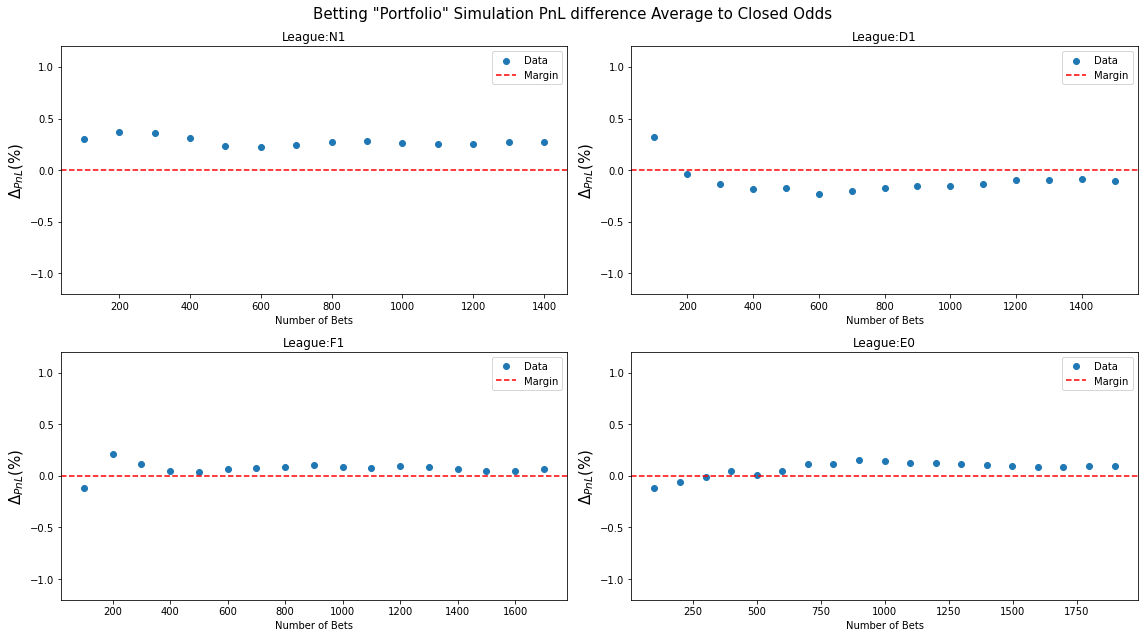

In [92]:
N_simulations = 10000
fig, axs = plt.subplots(2, 2,figsize=(16,9))
k = 0
for i in range(0,2):
    for j in range(0,2):
        sim = portfolio_stats_1x2(N_simulations = N_simulations,
                              df = df_total[df_total["Div"]==countries[k]],close = True)
        
        sim2 = portfolio_stats_1x2(N_simulations = N_simulations,
                              df = df_total[df_total["Div"]==countries[k]])
        no_bets = np.arange(100,1+len(sim[:,0]),100)
        if no_bets[-1] == len(sim[:,0]):
            no_bets = np.arange(100,1+len(sim[:,0]),100)-1
        axs[i, j].scatter(no_bets,100*(sim2[no_bets,0]-sim[no_bets,0])/no_bets)
        
        axs[i, j].axhline(y = 0, color = 'r', linestyle = 'dashed') 
        axs[i, j].set_title('League:'+countries[k])
        axs[i, j].set_xlabel('Number of Bets')
        axs[i, j].set_ylabel(r'$ \Delta_{PnL} (\%) $', fontsize = 15)   
        axs[i, j].legend(["Data","Margin"])
        axs[i, j].set_ylim(-1.2,1.2)
        k += 1

fig.suptitle('Betting "Portfolio" Simulation PnL difference Average to Closed Odds' , fontsize = 15)
plt.tight_layout()
plt.show()

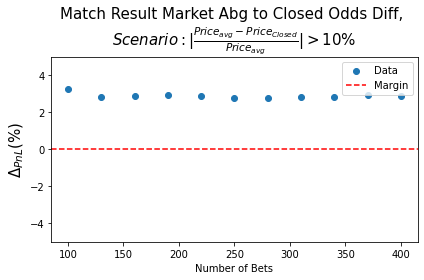

In [93]:
N_simulations = 5000
df_11 = df_total[((df_total["AvgH"]-df_total["AvgCH"])/df_total["AvgH"])>0.1]

sim = portfolio_stats_1x2(N_simulations = N_simulations,df = df_11,close = True)
sim2 = portfolio_stats_1x2(N_simulations = N_simulations,df = df_11)

no_bets = np.arange(100,1+len(sim[:,0]),30)
plt.scatter(no_bets,100*(sim2[no_bets,0]-sim[no_bets,0])/no_bets)        
plt.axhline(y = 0, color = 'r', linestyle = 'dashed') 
plt.title('Match Result Market Abg to Closed Odds Diff, \n' + r'$ Scenario : \| \frac{Price_{avg}-Price_{Closed}}{Price_{avg}} \| >  10 \% $' , fontsize = 15)
plt.xlabel('Number of Bets')
plt.ylabel(r'$ \Delta_{PnL} (\%) $', fontsize = 15)   
plt.legend(["Data","Margin"])
plt.ylim(-5,5)
plt.tight_layout()
plt.show()

# In every case, for different league and markets, one conclusion occurs for sure. You can't win the bookies in the main markets by just guessing what is going to happen